в этом файле тестирую сколько времени уходит на вычисление прогноза по уже построеному кешу.
получилось 27мс. но после вынесения операций савгол наружу, стало 4мс.

делал я это чтобы оценить сколько будет выполняться расчет, если делать мерж прогнозов в лоб со сложностью N^M, 
где N - количество ячеек прогноза, M - количество прогнозов. получается, если грубо 20^5, то будет считать 3.5 часа.
нафиг такой код. буду мержить видимо через слияние прогнозов по очереди.
сетку придется сделать побольше. например, 200. но сложность тогда будет 200*5. что должно дать ~ 4 секунды.

In [16]:
20*20*20*20*20*4/1000/60/60

3.555555555555556

In [2]:
%matplotlib widget

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Загружаем данные
file_path = "../npz/BTCUSD_1T.npz"
data = np.load(file_path, allow_pickle=True)
if 'data' in data:
    raw_data = data['data']
else:
    raise ValueError("Файл не содержит ключа 'data'")
columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
df = pd.DataFrame(raw_data, columns=columns)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
for col in ['open', 'high', 'low', 'close', 'volume']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
# При необходимости можно ограничить число точек:
#df = df.iloc[:50* 1000]


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from matplotlib.colors import LinearSegmentedColormap

# Helper function converts (x, y, z) to grid indices using bounds and grid_size.
def to_grid_3d(xx, yy, zz, bounds, grid_size):
    """
    Convert (xx, yy, zz) coordinates to grid indices.
    
    :param xx, yy, zz: Coordinates.
    :param bounds: Tuple (x_min, x_max, y_min, y_max, z_min, z_max).
    :param grid_size: Dictionary with keys 'x', 'y', 'z' for grid dimensions.
    :return: Tuple (i_x, i_y, i_z) representing the grid cell indices.
    """
    (x_min, x_max, y_min, y_max, z_min, z_max) = bounds
    i_x = int((xx - x_min) / (x_max - x_min) * (grid_size['x'] - 1))
    i_y = int((yy - y_min) / (y_max - y_min) * (grid_size['y'] - 1))
    i_z = int((zz - z_min) / (z_max - z_min) * (grid_size['z'] - 1))
    return (i_x, i_y, i_z)


def build_phase_space_grid_3d(df, window_short, window_long, tau, grid_size):
    """
    Разбивает фазовое пространство (x, y, z) на 3D-сетку и заполняет кэш переходов.
    Здесь:
      x = price_diff (0-я производная сглаженного относительного изменения цены)
      y = первая производная (относительное изменение скорости)
      z = вторая производная (ускорение изменения относительного изменения)
    
    :param df: DataFrame с ценами.
    :param window_short: короткое окно сглаживания.
    :param window_long: длинное окно сглаживания.
    :param tau: шаг прогноза (в баров).
    :param grid_size: словарь с размерами сетки, например {'x':50, 'y':50, 'z':50}.
    :return: (cache, bounds), где
             cache = { (i_x, i_y, i_z) -> { future_x: count } }
             bounds = (x_min, x_max, y_min, y_max, z_min, z_max)
    """
    polyorder = 3

    # Сглаживаем цену
    smoothed_short = savgol_filter(df['close'].values, window_short, polyorder)
    smoothed_long  = savgol_filter(df['close'].values, window_long, polyorder)
    
    # Относительное изменение (в процентах)
    rel_price_diff = (smoothed_short - smoothed_long) / smoothed_long

    # Вычисляем три координаты: 
    # x = базовый сигнал (разность),
    # y = первая производная,
    # z = вторая производная.
    x = savgol_filter(rel_price_diff, window_short, polyorder, deriv=0)
    y = savgol_filter(rel_price_diff, window_short, polyorder, deriv=1)
    z = savgol_filter(rel_price_diff, window_short, polyorder, deriv=2)
    
    # Границы фазового пространства
    x_min, x_max = np.min(x), np.max(x)
    y_min, y_max = np.min(y), np.max(y)
    z_min, z_max = np.min(z), np.max(z)
    bounds = (x_min, x_max, y_min, y_max, z_min, z_max)
    
    cache = {}  # { (i_x, i_y, i_z) -> { future_x: count } }
    n = len(x) - tau
    for t in range(n):
        cell_now = to_grid_3d(x[t], y[t], z[t], bounds, grid_size)
        cell_future = to_grid_3d(x[t+tau], y[t+tau], z[t+tau], bounds, grid_size)
        future_x = cell_future[0]  # Используем только x-компоненту будущей ячейки
        if cell_now not in cache:
            cache[cell_now] = {}
        if future_x not in cache[cell_now]:
            cache[cell_now][future_x] = 0
        cache[cell_now][future_x] += 1
    return cache, bounds


########################################################################
# Function to compute forecast data from the phase-space cache.
def compute_forecast_data(df, smoothed_short, smoothed_long, x, y, z, cache, bounds, window_short, window_long, tau, start_idx, end_idx, grid_size):
    """
    Compute forecast data (future points and counts) from the 3D phase-space cache.
    
    :param df: DataFrame with price data.
    :param cache: 3D-phase space cache (computed previously).
    :param bounds: Tuple (x_min, x_max, y_min, y_max, z_min, z_max).
    :param window_short: Short smoothing window.
    :param window_long: Long smoothing window.
    :param tau: Forecast step in bars.
    :param start_idx: Forecast start index.
    :param end_idx: Forecast end index.
    :param grid_size: Dictionary with grid dimensions (e.g., {'x':50, 'y':20, 'z':10}).
    :return: Tuple (forecast_points, forecast_counts, smoothed_short, smoothed_long)
             where forecast_points is a list of tuples (time, forecast_price, forecast_signal),
             forecast_counts is a list of corresponding counts.
    """
    (x_min, x_max, y_min, y_max, z_min, z_max) = bounds

    # Helper function to convert a single 3D point to a grid cell.
    def to_grid(xx, yy, zz):
        return to_grid_3d(xx, yy, zz, bounds, grid_size)

    forecast_points = []  # Will store tuples (current_time, forecast_price, forecast_signal)
    forecast_counts = []  # Will store forecast frequency counts
    N = len(x)
    for t in range(start_idx, min(end_idx, N - tau)):
        cell_now = to_grid(x[t], y[t], z[t])
        if cell_now in cache:
            for future_x, count in cache[cell_now].items():
                future_index = t + tau
                if future_index < N:
                    # Back-calculate the future x-value (price difference) from grid index.
                    future_price_diff = x_min + (future_x / (grid_size['x'] - 1)) * (x_max - x_min)
                    # Compute forecast price (a rough hypothesis for forecast).
                    forecast_price = future_price_diff * smoothed_long[t] + df['close'].iloc[t]
                    current_time = df.index[t]
                    forecast_points.append((current_time, forecast_price, future_price_diff * smoothed_long[t]))
                    forecast_counts.append(count)
    return forecast_points, forecast_counts

########################################################################
# Function to plot the forecast results using computed forecast data.
def plot_forecast(df, forecast_points, forecast_counts, smoothed_short, smoothed_long, tau, start_idx, end_idx):
    """
    Plot price forecast and forecast signal using forecast data.
    
    The function plots two subplots:
      - The top subplot shows the price, smoothed curves, and forecast points.
      - The bottom subplot shows the difference (short-long) and the corresponding forecast signal.
    
    :param df: DataFrame with price data.
    :param forecast_points: List of tuples (time, forecast_price, forecast_signal).
    :param forecast_counts: List of forecast frequency counts.
    :param smoothed_short: Array of short-window smoothed prices.
    :param smoothed_long: Array of long-window smoothed prices.
    :param tau: Forecast step in bars.
    :param start_idx: Start index for plotting.
    :param end_idx: End index for plotting.
    """
    fig, (ax, ax2) = plt.subplots(
        2, 1, figsize=(14, 7), gridspec_kw={'height_ratios': [5, 2]}
    )
    # Plot the original price and smoothed signals in the upper subplot.
    ax.plot(df.index[start_idx:end_idx], df['close'].iloc[start_idx:end_idx],
            label="BTC/USD Price", color='black', alpha=0.7)
    ax.plot(df.index[start_idx:end_idx],
            df['close'].shift(-tau).iloc[start_idx:end_idx],
            label="Price (tau ahead)", color='blue', alpha=0.7)
    ax.plot(df.index[start_idx:end_idx], smoothed_short[start_idx:end_idx],
            label="Short", color='red', alpha=0.7)
    ax.plot(df.index[start_idx:end_idx], smoothed_long[start_idx:end_idx],
            label="Long", color='green', alpha=0.7)
    ax.legend()
    
    # Plot the difference (short-long) in the lower subplot.
    diff = smoothed_short - smoothed_long
    ax2.plot(df.index[start_idx:end_idx], diff[start_idx:end_idx],
             label="Short-Long", color='black', alpha=0.7)
    ax2.plot(df.index[start_idx:end_idx], diff[start_idx+tau:end_idx+tau],
             label="Short-Long (tau shifted)", color='red', alpha=0.7)
    ax2.legend()
    
    # If forecast data exists, plot forecast points with color representing counts.
    if forecast_points:
        forecast_times, forecast_prices, forecast_signals = zip(*forecast_points)
        # Create a red gradient colormap (light red to deep red).
        red_gradient = LinearSegmentedColormap.from_list("red_gradient", ["#FFEEEE", "#FF0000"])
        ax.scatter(forecast_times, forecast_prices, c=forecast_counts, cmap=red_gradient,
                   alpha=0.5, s=19)
        ax2.scatter(forecast_times, forecast_signals, c=forecast_counts, cmap=red_gradient,
                    alpha=0.5, s=19)
    plt.tight_layout()
    plt.show()

###############################################################################
# Example usage:
# Assume 'df' is a DataFrame with a DatetimeIndex and a 'close' column.
# Also assume other parameters are defined (tau, window_short, window_long, grid_size).
N = len(df)
train_size = int(0.8 * N)
train_df = df.iloc[:train_size]
test_df  = df.iloc[train_size:]

tau = 10
window_short = 31
window_long  = 61

grid_size = {'x': 50, 'y': 20, 'z': 10}

# First, build the phase-space cache (this may be done separately).
cache_3d, bounds_3d = build_phase_space_grid_3d(train_df, window_short, window_long, tau, grid_size)

polyorder = 3
# Smooth the price series using the Savitzky-Golay filter.
smoothed_short = savgol_filter(test_df['close'].values, window_short, polyorder)
smoothed_long  = savgol_filter(test_df['close'].values, window_long, polyorder)
rel_price_diff = (smoothed_short - smoothed_long) / smoothed_long

# Compute x, y, z components (0th, 1st, 2nd derivatives).
x = savgol_filter(rel_price_diff, window_short, polyorder, deriv=0)
y = savgol_filter(rel_price_diff, window_short, polyorder, deriv=1)
z = savgol_filter(rel_price_diff, window_short, polyorder, deriv=2)



In [11]:
# Define indices for plotting forecast (for example: from window_long to window_long+300)
start_idx = window_long
end_idx = window_long + 300

# Compute future forecast data.
forecast_points, forecast_counts = compute_forecast_data(
    test_df, smoothed_short, smoothed_long, x, y, z, cache_3d, bounds_3d, window_short, window_long, tau, start_idx, end_idx, grid_size
)


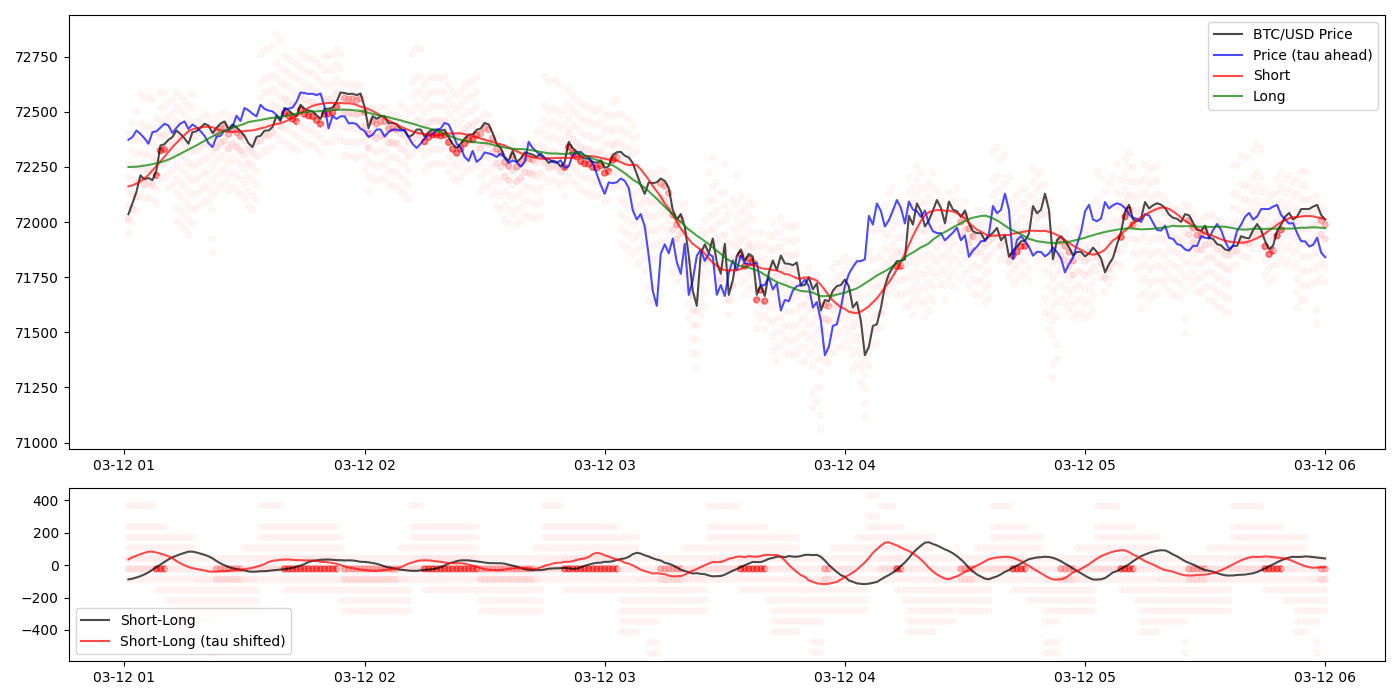

In [12]:

# Plot the forecast using the computed data.
plot_forecast(test_df, forecast_points, forecast_counts, smoothed_short, smoothed_long, tau, start_idx, end_idx)